In [1]:
%%capture
%pip install datasets evaluate

In [2]:
# Import necessary libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import re
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import torch
import time

# Download the Dataset

In [3]:
# Load the SQuAD dataset
dataset = load_dataset("squad")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [4]:
# Select only 10,000 records from the train split
small_dataset = dataset["train"].select(range(10000))
print(small_dataset)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10000
})


In [5]:
print(small_dataset['id'][0])
print(small_dataset['title'][0])
print(small_dataset['context'][0])
print(small_dataset['question'][0])
print(small_dataset['answers'][0])

5733be284776f41900661182
University_of_Notre_Dame
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


In [6]:
small_dataset[0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [7]:
small_dataset['answers'][0]

{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}

# Clean the Dataset

In [8]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Apply cleaning to the dataset
def clean_dataset(example):
    example["context"] = clean_text(example["context"])
    example["question"] = clean_text(example["question"])
    example["answers"]["text"] = [clean_text(ans) for ans in example["answers"]["text"]]
    return example

# Map cleaning function
cleaned_dataset = small_dataset.map(clean_dataset)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
cleaned_dataset[0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'architecturally the school has a catholic character atop the main buildings gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary',
 'question': 'to whom did the virgin mary allegedly appear in 1858 in lourdes france',
 'answers': {'text': ['saint bernadette soubirous'], 'answer_start': [515]}}

# Preprocess Data

In [10]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        max_length=512,
        truncation=True,
        padding="max_length",
        return_offsets_mapping=True
    )

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized_examples["offset_mapping"]):
        # Handle the case of multiple answers, selecting the first one
        answer = examples["answers"][i]
        answer_text = answer["text"][0] if isinstance(answer["text"], list) else answer["text"]
        start_char = answer["answer_start"] if isinstance(answer["answer_start"], int) else answer["answer_start"][0]
        end_char = start_char + len(answer_text)

        token_start = token_end = -1
        for idx, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                token_start = idx
            if start < end_char <= end:
                token_end = idx
                break

        start_positions.append(token_start)
        end_positions.append(token_end)

    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    tokenized_examples.pop("offset_mapping")  # Remove unnecessary field
    return tokenized_examples

# Tokenize the dataset
tokenized_dataset = cleaned_dataset.map(preprocess_function, batched=True)

# Optionally, inspect the tokenized dataset
print(tokenized_dataset[0])  # Print the first example in the train set

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'architecturally the school has a catholic character atop the main buildings gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary', 'question': 'to whom did the virgin mary allegedly appear in 1858 in lourdes france', 'answers': {'text': ['saint bernadette soubirous'], 'answer_start': [515]}, 'input_ids': [101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8

In [11]:
print(cleaned_dataset[1])
print(tokenized_dataset[1])

{'id': '5733be284776f4190066117f', 'title': 'University_of_Notre_Dame', 'context': 'architecturally the school has a catholic character atop the main buildings gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary', 'question': 'what is in front of the notre dame main building', 'answers': {'text': ['a copper statue of christ'], 'answer_start': [188]}}
{'id': '5733be284776f4190066117f', 'title': 'University_of_Notre_Dame', 'context': 'architectural

# Split Dataset

In [12]:
# Extract the train data and convert it into a DataFrame
train_df = pd.DataFrame(tokenized_dataset)

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(train_df, test_size=0.2, random_state=42)  # 80% train, 20% temp
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 50% of temp for validation/test

# Split the tokenized dataset into train, validation, and test sets
train_dataset, temp_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42).values()  # 80% train, 20% temp
validation_dataset, test_dataset = temp_dataset.train_test_split(test_size=0.5, seed=42).values()  # 50% of temp for validation/test

# Optionally, inspect the first record in each split to ensure the split was successful
print(train_dataset[0])  # Print the first example from the train split
print(validation_dataset[0])  # Print the first example from the validation split
print(test_dataset[0])  # Print the first example from the test split

{'id': '56d298dd59d6e41400146118', 'title': 'Buddhism', 'context': 'dwight goddard collected a sample of buddhist scriptures with the emphasis on zen along with other classics of eastern philosophy such as the tao te ching into his buddhist bible in the 1920s more recently dr babasaheb ambedkar attempted to create a single combined document of buddhist principles in the buddha and his dhamma other such efforts have persisted to present day but currently there is no single text that represents all buddhist traditions', 'question': 'goddard collected mainly what type of buddhist scripture', 'answers': {'text': ['zen'], 'answer_start': [79]}, 'input_ids': [101, 22547, 5067, 3701, 2054, 2828, 1997, 7992, 18919, 102, 14304, 22547, 5067, 1037, 7099, 1997, 7992, 22481, 2007, 1996, 7902, 2006, 16729, 2247, 2007, 2060, 10002, 1997, 2789, 4695, 2107, 2004, 1996, 20216, 8915, 19992, 2046, 2010, 7992, 6331, 1999, 1996, 6641, 2062, 3728, 2852, 14208, 3736, 5369, 2497, 2572, 8270, 6673, 4692, 2000, 

# Perform Initial Data Analysis

#### Analyze Question Length Distribution

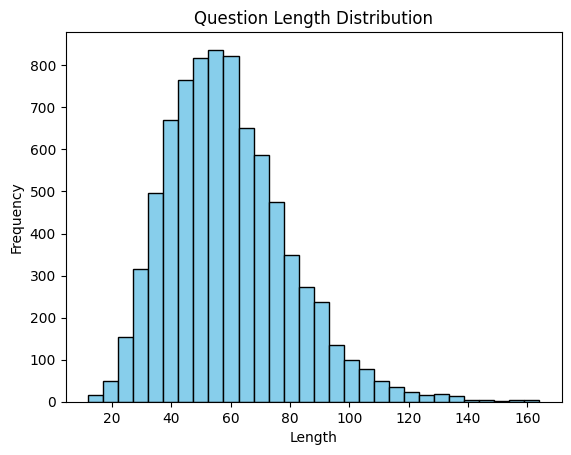

In [13]:
import matplotlib.pyplot as plt

# Analyze question length
train_data["question_length"] = train_data["question"].apply(len)
plt.hist(train_data["question_length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Question Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

#### Analyze Answer Length Distribution

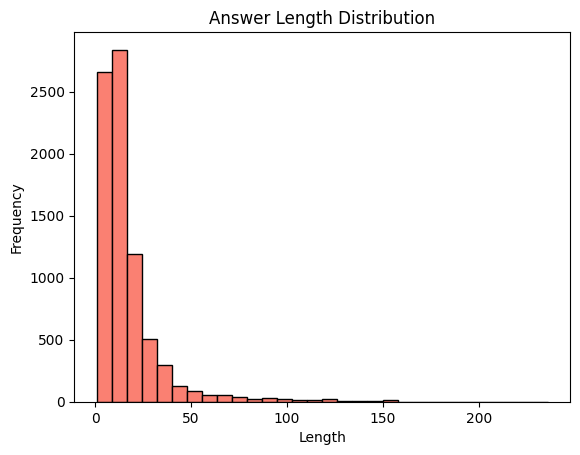

In [14]:
# Analyze answer length
train_data["answer_length"] = train_data["answers"].apply(lambda x: len(x["text"][0]) if x["text"] else 0)
plt.hist(train_data["answer_length"], bins=30, color="salmon", edgecolor="black")
plt.title("Answer Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

#### Context Distribution

In [15]:
# Unique contexts
unique_contexts = train_data["context"].nunique()
print(f"Unique Contexts in Training Set: {unique_contexts}")

# Top 10 frequent contexts
top_contexts = train_data["context"].value_counts().head(10)
print("Top 10 Frequent Contexts:\n", top_contexts)

Unique Contexts in Training Set: 1840
Top 10 Frequent Contexts:
 context
beyonc giselle knowlescarter bijnse beeyonsay born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destinys child managed by her father mathew knowles the group became one of the worlds bestselling girl groups of all time their hiatus saw the release of beyoncs debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy                                                                                                                                                                                                                                                                                    

# Model Implementation and Fine-Tuning

In [16]:
# Compute metrics function
def compute_metrics(p):
    predictions, labels = p
    start_logits, end_logits = predictions

    # Convert logits to predictions
    start_predictions = torch.argmax(torch.tensor(start_logits), dim=1).tolist()
    end_predictions = torch.argmax(torch.tensor(end_logits), dim=1).tolist()

    # Generate prediction_text and references in the expected format
    predictions_dict = []
    references_dict = []

    for i in range(len(start_predictions)):
        # Decode predicted answer text
        input_ids = tokenized_dataset[i]["input_ids"]
        prediction_text = tokenizer.decode(input_ids[start_predictions[i]:end_predictions[i] + 1], skip_special_tokens=True)
        predictions_dict.append({
            "id": tokenized_dataset[i]["id"],
            "prediction_text": prediction_text
        })

        # Add reference answers
        references_dict.append({
            "id": tokenized_dataset[i]["id"],
            "answers": {
                "text": tokenized_dataset[i]["answers"]["text"],
                "answer_start": tokenized_dataset[i]["answers"]["answer_start"]
            }
        })

    # Compute the evaluation metric
    results = metric.compute(predictions=predictions_dict, references=references_dict)
    return results

In [17]:
# Initialize the BERT model for Question Answering
model = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")

# Load the evaluation metric
metric = evaluate.load("squad")

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_steps=500,
    save_total_limit=2,
    report_to="none",  # Disable WandB
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Exact Match,F1
1,3.630000,3.319270,0.000000,0.016667


TrainOutput(global_step=500, training_loss=3.904856140136719, metrics={'train_runtime': 834.7655, 'train_samples_per_second': 9.584, 'train_steps_per_second': 0.599, 'total_flos': 2090374053888000.0, 'train_loss': 3.904856140136719, 'epoch': 1.0})

In [19]:
trainer.evaluate()

{'eval_loss': 3.319270133972168,
 'eval_exact_match': 0.0,
 'eval_f1': 0.016666666666666666,
 'eval_runtime': 36.2879,
 'eval_samples_per_second': 27.557,
 'eval_steps_per_second': 1.736,
 'epoch': 1.0}

In [20]:
# Evaluate the model on the test dataset
evaluation_results = trainer.evaluate(test_dataset)
print("Evaluation Results:", evaluation_results)

Evaluation Results: {'eval_loss': 3.366024971008301, 'eval_exact_match': 0.0, 'eval_f1': 0.007492997198879553, 'eval_runtime': 36.2211, 'eval_samples_per_second': 27.608, 'eval_steps_per_second': 1.739, 'epoch': 1.0}


# Model Evaluation & Comparative Analysis

In [21]:
# Add the device management part right before inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Inference and performance analysis
start_time = time.time()

# Select one example from the test dataset
sample = test_dataset[0]  # Access the first record from the test dataset

# Ensure the inputs include the necessary fields for the model
inputs = {
    'input_ids': torch.tensor(sample['input_ids']).unsqueeze(0).to(device),  # Add batch dimension and move to device
    'attention_mask': torch.tensor(sample['attention_mask']).unsqueeze(0).to(device),  # Add batch dimension and move to device
}

# If token_type_ids exists in the dataset, include it as well
if 'token_type_ids' in sample:
    inputs['token_type_ids'] = torch.tensor(sample['token_type_ids']).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Ensure the model receives all the required inputs
with torch.no_grad():
    outputs = model(**inputs)

inference_time = time.time() - start_time
print(f"Inference Time for 1 sample: {inference_time:.4f} seconds")

# Model size
model_size = sum(p.numel() for p in model.parameters()) / (1024**2)  # Size in MB
print(f"Model Size: {model_size:.2f} MB")

# Model performance
accuracy = evaluation_results.get('eval_accuracy', 'N/A')
f1_score = evaluation_results.get('eval_f1', 'N/A')
print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1_score}")

Inference Time for 1 sample: 0.0514 seconds
Model Size: 103.85 MB
Accuracy: N/A
F1-Score: 0.007492997198879553
